In [1]:
import numpy as np
import os
from myplotstyle import plt,get_figsize

from astropy import table
from astropy.table import Table, Column
from astropy.io import ascii, fits

from astropy import units as u
from astropy.coordinates import SkyCoord
import pyspherematch as sm

from astropy.table import vstack

import glob
from dmost.core import dmost_utils,dmost_chi2_template

data_dir     = os.getenv('DEIMOS_REDUX')

In [2]:
######################################################
# READ DEIMOS OBJECT GOOGLE DOCUMENT
def deimos_google():
    key = '1V2aVg1QghpQ70Lms40zNUjcCrycBF2bjgs-mrp6ojI8'
    gid=1906496323
    url = 'https://docs.google.com/spreadsheets/d/{0}/export?format=csv&gid={1}'.format(key, gid)
    masklist = Table.read(url, format='csv')

    gid =0
    url = 'https://docs.google.com/spreadsheets/d/{0}/export?format=csv&gid={1}'.format(key, gid)
    objlist = ascii.read(url, format='csv')
    
    return objlist,masklist

objlist, masklist = deimos_google()
m = masklist['Project'] == 'MW'
masklist=masklist[m]

In [3]:
DateObs_18mon = 20231210

m  = (masklist['DateObs'] < DateObs_18mon) & (masklist['pypeit_redux'] != 'N') &\
                                    (masklist['pypeit_redux'] != 'S')&(masklist['Project'] == 'MW')
masklist=masklist[m]
print(np.size(masklist))

414


In [4]:
plt.rcParams.update({
    "figure.constrained_layout.use": True,
    "figure.dpi": 200,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "font.size": 15,
    "axes.labelsize": 16,
    "legend.frameon": False,
    "legend.handletextpad": 0.5,
    "lines.markersize": 5,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 7,
    "xtick.minor.size": 4,
    "ytick.major.size": 7,
    "ytick.minor.size": 4,
    "savefig.bbox": "tight",
    "savefig.dpi": 200,
})

In [5]:
airmass, h2o,o2 = [],[],[]
msk,fn,mjd = [],[],[]
seeing = []
n_mask=0
n_exp=0


for mask in masklist['MaskName']: 
    
    dmost_file = data_dir + mask+'/dmost/dmost_'+mask+'.fits'
    
    if os.path.isfile(dmost_file):
        slits, mask = dmost_utils.read_dmost(dmost_file)
    
    
        n_mask = n_mask+1
        for ii in np.arange(0,mask['nexp'][0],1):
            airmass = np.append(airmass,mask['airmass'][ii])
            h2o = np.append(h2o,mask['telluric_h2o'][ii])  
            o2 = np.append(o2,mask['telluric_o2'][ii])
            msk = np.append(msk,mask['maskname'][ii])
            fn = np.append(fn,mask['fname'][ii])
            mjd = np.append(mjd,mask['mjd'][ii])

            n_exp=n_exp+1

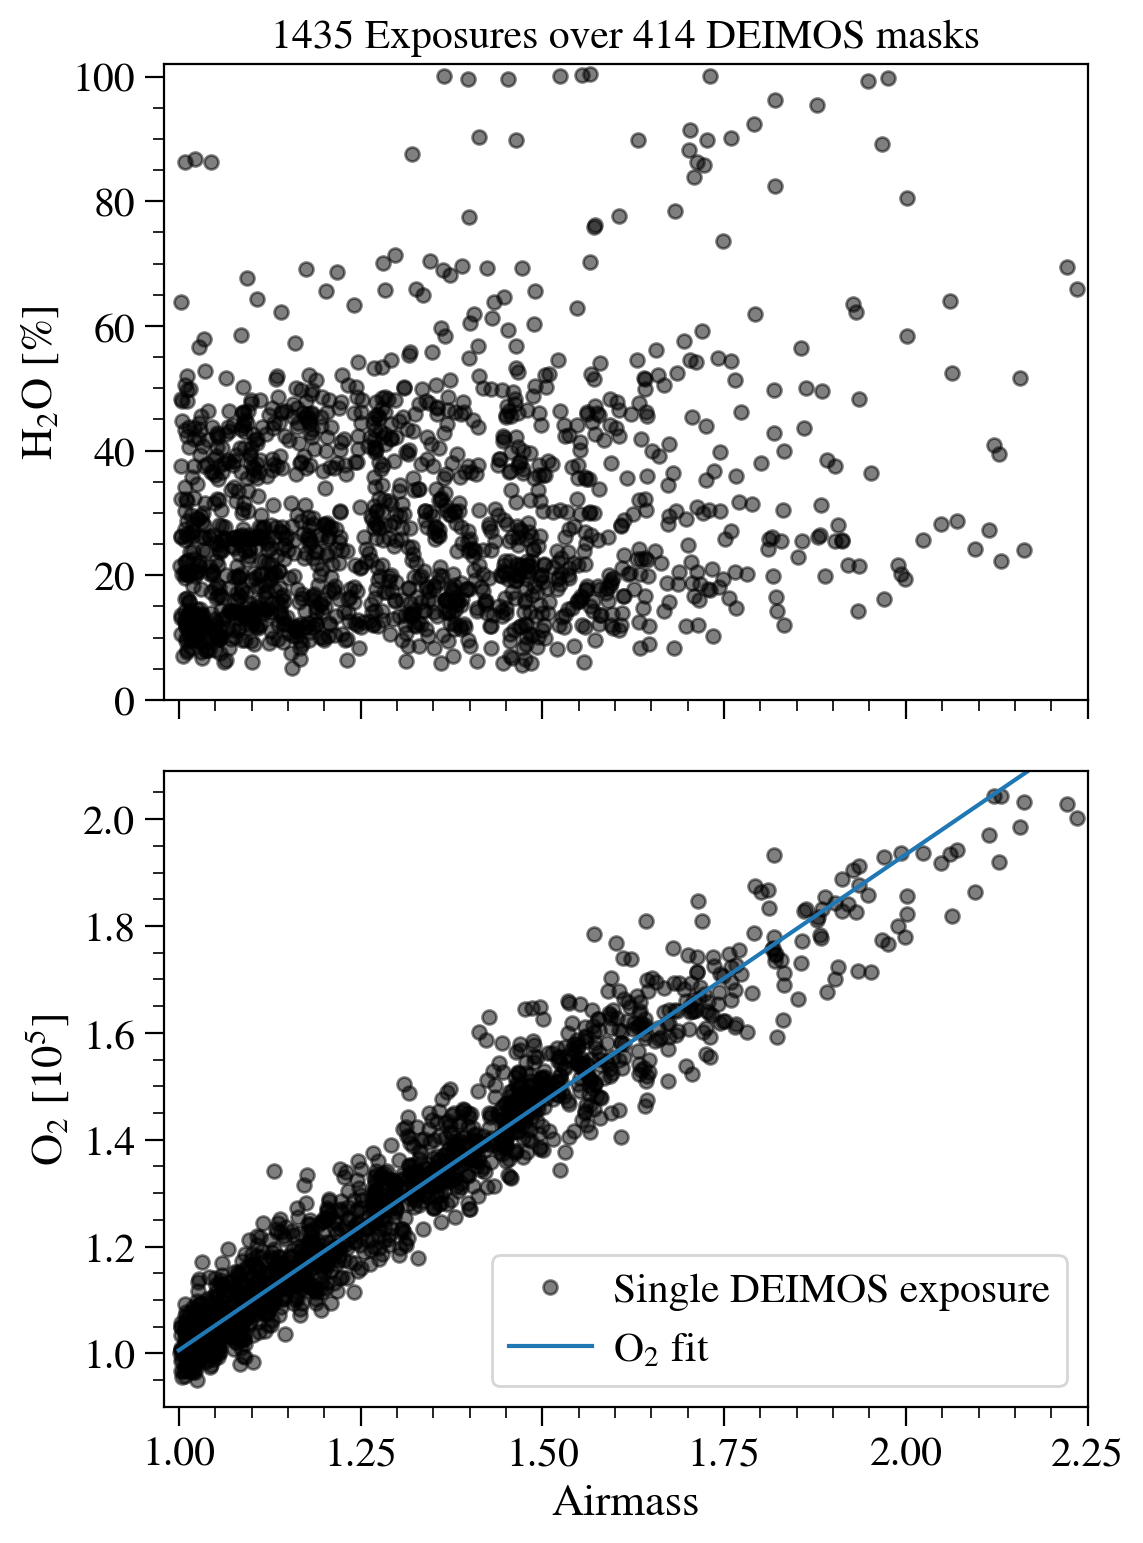

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(6,8),sharex=True)
plt.rcParams.update({'font.size': 16})
fig.subplots_adjust(hspace=0.00)


m1=(o2 < 0.97)
m2= (airmass > 1.25)  &(o2 < 1.05) 
m3= (airmass > 1.45)  &(o2 < 1.2) 
m4= (airmass > 2)  &(o2 < 1.5) 


m = m2|m1|m3|m4
ax1.plot(airmass,h2o+h2r,'o',c='k',alpha=0.5)
ax2.plot(airmass[~m],o2[~m]+o2r[~m],'o',c='k',alpha=0.5,label='Single DEIMOS exposure')

ax2.set_xlabel('Airmass')
ax1.set_ylabel('H$_2$O [%]')
ax2.set_ylabel(r'O$_2$ [$10^5$]')
ax1.set_title('{} Exposures over {} DEIMOS masks'.format(n_exp,n_mask),fontsize=15)

ax1.set_ylim(0,102)
ax2.set_ylim(0.9,2.09)

ax1.set_xlim(0.98,2.25)
ax2.set_xlim(0.98,2.25)


mm = airmass < 2.0
m,b = np.polyfit(airmass[mm],o2[mm], 1)
x=np.arange(1,2.2,0.1)

m= 0.928209438
b= 0.07763335
y=m*x + b
ax2.plot(x,y,label='O$_2$ fit')
ax2.legend(fontsize=15,loc='lower right',frameon=True)


plt.tight_layout()
plt.savefig('figure_telluric_all.pdf')